In [ ]:
!pip install ket-lang[plot]==0.9.1.2 kaleido==0.2.1 pyqubo -q     

O Algoritmo Quântico de Otimização Aproximada, ou Quantum Aproximation Optimization Algorithm, (QAOA) é um dos algoritmos variacionais mais importantes da computação quântica, projetado para resolver problemas de otimização combinatória de forma eficiente. Ele combina elementos da mecânica quântica e da otimização clássica, utilizando um circuito quântico parametrizado para buscar soluções aproximadas para problemas difíceis de resolver por métodos convencionais. 

# Algoritmo Quântico de Otimização Aproximada (QAOA)

O QAOA é um algoritmo que busca minimizar uma função de custo aplicada a uma sequência de bits. Dessa forma, ele se baseia na implementação de dois hamiltonianos, o hamiltoniano de custo (Cost) $H_c$ e o hamiltoniano misturador (Mixer) $H_m$ que são aplicados de forma sequencial $n$ vezes.

$$
minimizar \space C(z)
$$

Em que $C$ é a função custo que mede a precisão de cada solução e $z$ é uma sequência de bits.

## Estrutura do Algorítmo

O QAOA é um algoritmo híbrido clássico-quântico, ou seja:

- Uma parte quântica prepara estados e mede resultados.

- Uma parte clássica ajusta parâmetros para melhorar a performance.

Ele funciona como um circuito quântico **parametrizado por dois conjuntos de parâmetros**:

$$
\boldsymbol{\gamma} = (\gamma_1, ..., \gamma_p), \quad \boldsymbol{\beta} = (\beta_1, ..., \beta_p)
$$

onde $p$ é a “profundidade” do algoritmo (quanto maior, mais preciso — mas mais difícil de executar).

Além disso, ele utiliza de um sistema de dois hamiltonianos, um que representa o problema a ser otimizado, **hamiltoniano de custo** ($H_c$) e um altera os bits, **hamiltoniano de mistura** ($H_m$).

![qaoa](../../images/algoritmos/qaoa/qaoa.png)

### Hamiltoniano de Custo (Cost)

O **hamiltoniano de custo** é o responsável por **codificar o problema de otimização** no sistema quântico.
Cada possível solução $z$ (uma sequência de bits) é associada a um valor de energia proporcional ao custo $C(z)$. O objetivo é encontrar o estado quântico que minimize essa energia esperada.

De modo geral, $H_c$ é **diagonal na base computacional**, e sua forma depende do problema que se deseja resolver.

Por exemplo, para o problema **Max-Cut**, o hamiltoniano de custo é dado por:

$$
H_c = \sum_{(i,j) \in E} \frac{1 - Z_i Z_j}{2}
$$

onde:

* $E$ é o conjunto de arestas do grafo,
* $Z_i$ e $Z_j$ são operadores de Pauli-Z aplicados aos qubits $i$ e $j$.

Esse termo atribui energia menor (ou custo maior) às configurações de bits que **maximizam o número de arestas “cortadas”**, ou seja, que conectam vértices em partições diferentes do grafo.

### Hamiltoniano de Mistura (Mixer)

O **hamiltoniano de mistura** tem o papel de **explorar o espaço de soluções**, permitindo que o sistema quântico escape de mínimos locais.

Ele é definido, de forma geral, como:

$$
H_m = \sum_{i} X_i
$$

onde $X_i$ é o operador de Pauli-X aplicado ao qubit $i$.

O operador $X_i$ realiza rotações entre os estados $\ket{0}$ e $\ket{1}$, ou seja, **muda os bits das soluções** de forma controlada pelos parâmetros $\beta$.
Assim, enquanto $H_c$ “atrai” o sistema para as boas soluções, $H_m$ garante diversidade e exploração — evitando que o algoritmo se prenda a uma única configuração.

# Aplicando QAOA no Max-Cut

Para ilustrar o funcionamento do QAOA, o problema do **Max-Cut** é frequentemente utilizado como exemplo. Esse problema consiste em **dividir os vértices de um grafo em dois grupos** de modo a **maximizar o número de arestas que conectam vértices de grupos diferentes**.

## O Problema do Max-Cut

Dado um grafo $G = (V, E)$ com vértices $V$ e arestas $E$, queremos encontrar uma partição dos vértices $V$ em dois subconjuntos $S$ e $\bar{S}$ tal que o número de arestas entre eles seja máximo.

O custo clássico pode ser expresso como:

$$
C(z) = \sum_{(i,j)\in E} \frac{1 - z_i z_j}{2}
$$

onde $z_i, z_j \in {+1, -1}$ representam a qual subconjunto cada vértice pertence.

![Max-cut](../../images/algoritmos/qaoa/Max-cut.svg)

## QAOA em Max-Cut

No contexto quântico, o QAOA começa com todos os qubits no estado $\ket{+}^{\otimes n}$, criando uma **superposição uniforme** de todas as possíveis soluções.

Em seguida, aplica-se alternadamente os dois hamiltonianos controlados pelos parâmetros $\gamma$ e $\beta$:

$$
\ket{\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})} =
e^{-i \beta_p H_m} e^{-i \gamma_p H_c}
\cdots
e^{-i \beta_1 H_m} e^{-i \gamma_1 H_c}
\ket{+}^{\otimes n}
$$

Após medir o estado final, obtemos bitstrings $z$, e o valor de $C(z)$ é calculado classicamente. O algoritmo clássico então ajusta os parâmetros $\boldsymbol{\gamma}$ e $\boldsymbol{\beta}$ para **maximizar o valor esperado** de $C(z)$, repetindo o processo até convergir para uma solução próxima do ótimo.

Dessa forma, o QAOA realiza um **equilíbrio entre exploração (via $H_m$) e otimização (via $H_c$)**, aproximando a solução ótima do problema combinatório através da interferência quântica controlada.

## Simulação do Algoritmo Quântico de Otimização Aproximada (QAOA) no Problema do Max-Cut

Para simular o QAOA usaremos a línguagem Ket de computação quântica, para isso precisamos ter ela instalada, caso não possua o pacote instalado rode o seguinte código:

```python
pip install ket-lang
```

Com a biblioteca instalada, importa-se para ser usada dentro do seu código:

In [85]:
from ket import *
from ket import ket_version
from scipy.optimize import minimize
from functools import partial

Para implementar o QAOA no problema do Max-Cut devemos primeiramente definir o hamiltoniano de custo $(H_c)$

In [86]:
def cost_h(edges, qubits):
    with obs():
        return -1 / 2 * sum(1 - Z(qubits[a]) * Z(qubits[b]) for a, b in edges)

Agora implementaremos o hamiltoniano misturador ($H_m$)

In [87]:
def mixer_h(qubits):
    with obs():
        return sum(X(q) for q in qubits)

Após isso, devemos implementar o otimizador clássico, visando a evolução temporal

In [88]:
def qaoa_layer(edges, gamma, alpha, qubits):
    evolve(cost_h(edges, qubits) * gamma)
    evolve(mixer_h(qubits) * alpha)

Utilizando do ket, conseguimos plotar o circuito referente ao algoritmo

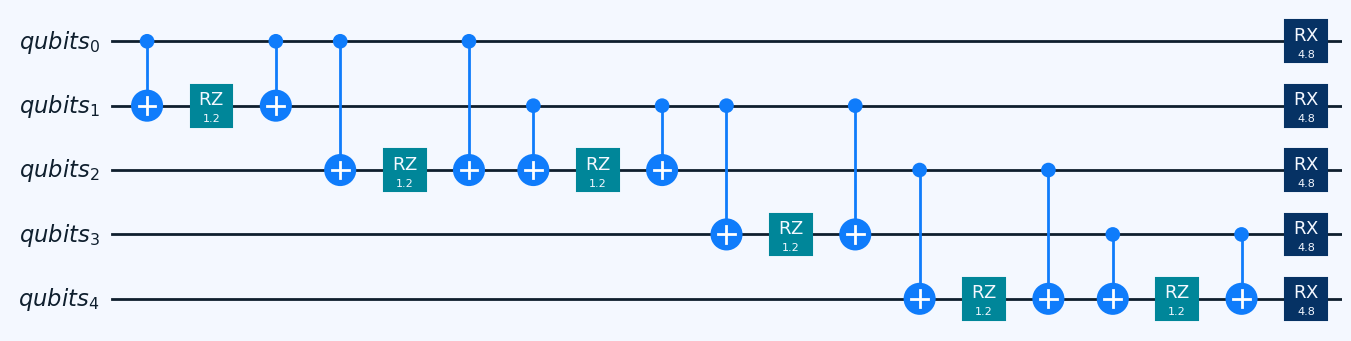

In [89]:
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]
num_nodes = len(edges) - 1

qulib.draw(qaoa_layer, num_nodes, (edges, 1.2, 2.4))

Agora, podemos definir o QAOA aplicando sua evolução temporal 

In [90]:
def qaoa(param, edges, num_nodes):
    p = len(param) // 2
    gamma, alpha = param[:p], param[p:]

    process = Process()
    qubits = process.alloc(num_nodes)

    H(qubits)
    for g, a in zip(gamma, alpha):
        qaoa_layer(edges, g, a, qubits)

    return qubits


def objective(param, edges, num_nodes):
    qubits = qaoa(param, edges, num_nodes)
    return exp_value(cost_h(edges, qubits)).get()

Resultados:

In [91]:
p = 4
params = [0.5 for _ in range(p * 2)]

res = minimize(
    partial(objective, edges=edges, num_nodes=num_nodes),
    params,
    method="COBYLA",
)

print(res)

sample(qaoa(res.x, edges, num_nodes)).histogram("bin")

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -4.827249509782471
       x: [ 8.851e-01 -3.935e-01  1.072e+00 -1.900e-01  3.221e-01
           -8.118e-01 -7.194e-01  5.154e-01]
    nfev: 1000
   maxcv: 0.0


# Aplicando QAOA ao QUBO

Uma de suas aplicações mais diretas do QAOA é no **QUBO** (*Quadratic Unconstrained Binary Optimization*), um formato genérico que abrange inúmeros problemas reais, desde escalonamento e roteamento até clustering e design de portfólios.

## O que é o QUBO

O QUBO pode ser entendido como um problema onde buscamos um vetor binário $z = (z_1, z_2, ..., z_n)$, com cada $z_i \in {+1, -1}$, que minimize (ou maximize) uma função de custo quadrática da forma:

$$
C(z) = \sum_{i<j} w_{ij} z_i z_j + \sum_i w_i z_i
$$

onde $w_{ij}$ e $w_i$ são pesos associados às interações e aos vértices, respectivamente.

Um exemplo clássico é o **problema de Max-Cut**, onde o objetivo é dividir os vértices de um grafo em dois grupos de modo a maximizar o número de arestas entre eles. Nesse caso, o custo pode ser escrito como:

$$
C(z) = \sum_{(i,j)\in E} \frac{1 - z_i z_j}{2}
$$

## QAOA ao QUBO

O QAOA traduz o problema QUBO para o domínio quântico utilizando dois **Hamiltonianos**:

* O **Hamiltoniano de Custo**, $H_c$, codifica a função objetivo do problema (no caso do Max-Cut, ele depende das arestas do grafo).
* O **Hamiltoniano Misturador**, $H_m$, atua sobre os qubits permitindo a exploração do espaço de soluções.

O algoritmo começa com todos os qubits no estado:

$$
\ket{+}^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_z \ket{z}
$$

criando uma **superposição uniforme** de todas as possíveis configurações binárias.

Em seguida, aplica-se uma sequência alternada dos operadores de evolução controlados pelos parâmetros $\gamma$ e $\beta$:

$$
\ket{\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})} =
e^{-i \beta_p H_m} e^{-i \gamma_p H_c}
\cdots
e^{-i \beta_1 H_m} e^{-i \gamma_1 H_c}
\ket{+}^{\otimes n}
$$

Após medir o estado final, obtemos diferentes bitstrings $z$, e o valor da função $C(z)$ é calculado **classicamente**. Um otimizador clássico ajusta então os parâmetros $\boldsymbol{\gamma}$ e $\boldsymbol{\beta}$ para **maximizar o valor esperado de $C(z)$**.

Esse ciclo híbrido (quântico + clássico) é repetido até que os parâmetros convirjam para uma configuração próxima da solução ótima.

## Simulação do Algoritmo Quântico de Otimização Aproximada (QAOA) ao QUBO

Para simular o QAOA usaremos a línguagem Ket de computação quântica, para isso precisamos ter ela instalada, caso não possua o pacote instalado rode o seguinte código:

```python
pip install ket-lang
```

Com a biblioteca instalada, importa-se para ser usada dentro do seu código:

In [92]:
from functools import partial
from math import prod
from ket import *
from ket import ket_version
from scipy.optimize import minimize
from pyqubo import Array

Para implementar o QAOA no problema QUBO devemos primeiramente definir o portifólio

In [93]:
def portfolio(
    exp_return: list[float],
    cov_matrix: list[list[float]],
    budget: int,
    risk: float = 0.5,
    penalty: float = 1,
):
    if not (0 <= risk <= 1):
        raise ValueError("risk must be between 0 and 1")

    num_assets = len(exp_return)

    if num_assets != len(cov_matrix):
        raise ValueError(f"cov_matrix must be square {num_assets}x{num_assets}")

    if not (0 <= budget <= num_assets):
        raise ValueError(f"budget must be between 0 and {num_assets}")

    assets = Array.create("assets", shape=(num_assets,), vartype="BINARY")

    return -(
        sum(map(prod, zip(assets, exp_return)))
        - risk
        * sum(
            cov_matrix[i][j] * assets[i] * assets[j]
            for i in range(num_assets)
            for j in range(i + 1, num_assets)
        )
        - penalty * (budget - sum(assets)) ** 2
    )

Agora definimos os Hamiltonianos (mixel e custo), que já está nativamente no Ket, e suas camadas

In [94]:
cost_h = qulib.ham.qubo
mixer_h = qulib.ham.x_mixer


def qaoa_layer(model, gamma, alpha, qubits):
    evolve(cost_h(model, qubits) * gamma)
    evolve(mixer_h(qubits) * alpha)

Utilizando do ket, conseguimos plotar o circuito referente ao algoritmo

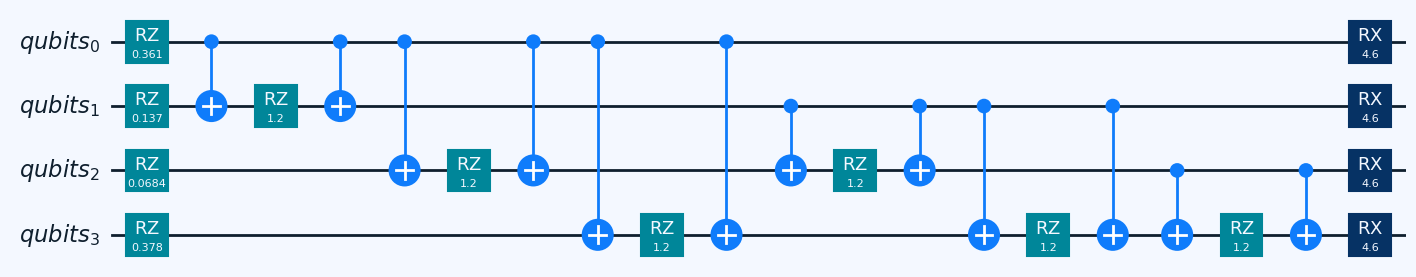

In [95]:
cov = [
    [1.08774352e-03, 2.59532811e-04, 1.80247155e-04, 3.21724369e-04],
    [2.59532811e-04, 4.43192629e-04, 7.43211072e-05, 2.27911525e-04],
    [1.80247155e-04, 7.43211072e-05, 3.89444953e-04, 1.37915422e-04],
    [3.21724369e-04, 2.27911525e-04, 1.37915422e-04, 8.75437564e-04],
]

mu = [0.31542042, 0.0571331, 0.11430001, 0.30109367]

h = portfolio(exp_return=mu, cov_matrix=cov, budget=2, risk=0.5)

model = h.compile()

qulib.draw(qaoa_layer, 4, (model, 1.2, 2.3), fold=-1)

Agora, podemos definir o QAOA aplicando sua evolução temporal 

In [96]:
def qaoa(param, model, size):
    p = len(param) // 2
    gamma, alpha = param[:p], param[p:]

    process = Process()
    qubits = process.alloc(size)

    H(qubits)
    for g, a in zip(gamma, alpha):
        qaoa_layer(model, g, a, qubits)

    return qubits


def objective(param, model, size):
    qubits = qaoa(param, model, size)
    return exp_value(cost_h(model, qubits)).get

In [97]:
from dimod import ExactSolver

bqm = model.to_bqm()
sa = ExactSolver()
sampleset = sa.sample(bqm)
sampleset.to_pandas_dataframe().sort_values("energy")

,assets[0],assets[1],assets[2],assets[3],energy,num_occurrences
2,1,0,0,1,-0.616353,1
4,1,0,1,0,-0.429630,1
6,0,0,1,1,-0.415325,1
12,1,1,0,0,-0.372424,1
14,0,1,0,1,-0.358113,1
8,0,1,1,0,-0.171396,1
5,1,0,1,1,0.269506,1
13,1,1,0,1,0.326757,1
11,1,1,1,0,0.513404,1
9,0,1,1,1,0.527693,1
